# BA820 Project Proposal: M2

**Course:** BA820 - Unsupervised and Unstructured Machine Learning  
 **Authors:**  Xiaoqing Ye (Quency)


---

## Executive Summary

• Grouping counties with similar economic and demographic characteristics helps define what “normal” affordability looks like for comparable places.

• Within these peer groups, a small but meaningful share of counties show childcare costs that are much higher or lower than expected.

• About 5% of counties are identified as contextual anomalies, including both high-burden counties under unexpected pressure and low-burden counties that achieve unusually affordable childcare.

• Sensitivity checks show that these findings are stable across different model choices and thresholds.

• The results indicate that income and labor conditions alone do not fully explain childcare affordability outcomes.

## 1. Dataset Overview

###  Dataset: National Database of Childcare Prices

**Source:** U.S. Department of Labor Women's Bureau (via TidyTuesday)  
**URL:** https://github.com/rfordatascience/tidytuesday/tree/main/data/2023/2023-05-09

| Characteristic | Details |
|---------------|---------|
| **Observations** | 34,567 county-year combinations |
| **Variables** | 61 features (costs, income, labor, demographics, households) |
| **Temporal** | 2008-2018 (Great Recession → Recovery) |
| **Geographic** | U.S. counties (FIPS coded) |

## Analysis Domain Question
Can anomaly detection methods identify counties functioning as contextual outliers
where childcare affordability burden deviates substantially from predicted values,
and what institutional, geographic, or historical factors explain these anomalous
patterns?

### 🔍 Key Variables

- **Childcare Costs:** `mcsa` (school-age), `mc_infant`, `mc_toddler`, `mc_preschool`, `mfcc_infant`, `mfcc_toddler`, `mfcc_preschool`  
- **Income Variable:** `mhi_2018` (income), `me_2018`
- **Labor market:** `unr_20to64`(unemployment rate), `flfpr_20to64`(female labor), `mlfpr_20to64`
- **Household structure:** `h_under6_both_work`, `h_under6_single_m`
- **Employment mix:**: `emp_service`, `emp_sales`, `emp_p`



## 2. Load the data


In [31]:
# Install packages (Colab only)
!pip install -q seaborn>=0.12.0 scikit-learn>=1.2.0

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configure visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print(" Setup complete - libraries imported and configured")

 Setup complete - libraries imported and configured


In [33]:
# Load Childcare Costs dataset
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-05-09/childcare_costs.csv"
df_childcare = pd.read_csv(url)

# Quick data overview
print("=" * 80)
print("CHILDCARE COSTS DATASET - STRUCTURE")
print("=" * 80)
print(f"Shape: {df_childcare.shape[0]:,} rows × {df_childcare.shape[1]} columns")
print(f"Time range: {df_childcare['study_year'].min()}-{df_childcare['study_year'].max()}")
print(f"Counties: {df_childcare['county_fips_code'].nunique():,}")
print(f"Missing values: {df_childcare.isnull().sum().sum():,} total")
print(f"\nKey variables present: mcsa ✓, mhi_2018 ✓, flfpr_20to64 ✓")

# Display sample
print("\n Sample Data (first 3 rows):")
df_childcare[['study_year', 'county_fips_code', 'mcsa', 'mhi_2018', 'flfpr_20to64']].head(3)

CHILDCARE COSTS DATASET - STRUCTURE
Shape: 34,567 rows × 61 columns
Time range: 2008-2018
Counties: 3,144
Missing values: 88,636 total

Key variables present: mcsa ✓, mhi_2018 ✓, flfpr_20to64 ✓

 Sample Data (first 3 rows):


,study_year,county_fips_code,mcsa,mhi_2018,flfpr_20to64
0,2008,1001,80.92,58462.55,68.9
1,2009,1001,83.42,60211.71,70.8
2,2010,1001,85.92,61775.80,71.3


In [34]:
# Finding dataset summary: columns, data types, and missingness
def dataset_summary(df, name):
    print(f"\n===== {name} =====")
    print()
    df.info()
    print()
    display(df.describe(include="all"))

# Analyze childcare dataset
dataset_summary(df_childcare, "Childcare Costs Dataset")


===== Childcare Costs Dataset =====

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   county_fips_code           34567 non-null  int64  
 1   study_year                 34567 non-null  int64  
 2   unr_16                     34567 non-null  float64
 3   funr_16                    34567 non-null  float64
 4   munr_16                    34567 non-null  float64
 5   unr_20to64                 34567 non-null  float64
 6   funr_20to64                34567 non-null  float64
 7   munr_20to64                34567 non-null  float64
 8   flfpr_20to64               34567 non-null  float64
 9   flfpr_20to64_under6        34567 non-null  float64
 10  flfpr_20to64_6to17         34567 non-null  float64
 11  flfpr_20to64_under6_6to17  34567 non-null  float64
 12  mlfpr_20to64               34567 non-null  float64
 13  pr_f    

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,...,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool
count,34567.000000,34567.000000,34567.000000,34567.00000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,...,34567.000000,34567.000000,23593.000000,23383.000000,23593.000000,23593.000000,23593.000000,23383.000000,23383.000000,23383.000000
mean,30388.132786,2012.999711,7.465902,7.02902,7.860291,6.900073,6.482007,7.275457,70.086125,68.821409,...,23.456238,7.634403,101.234253,92.523582,146.051770,130.482768,122.232852,113.421657,106.759749,104.189510
std,15161.015383,3.162232,3.538619,3.56342,4.037657,3.446199,3.477956,3.990758,7.696499,11.758088,...,7.956927,4.501044,34.552888,27.669904,53.698566,43.775370,38.538323,32.819372,29.982431,28.961701
min,1001.000000,2008.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,33.600000,0.000000,...,0.000000,0.000000,18.980000,22.000000,27.730000,21.540000,21.540000,43.080000,43.080000,40.030000
25%,18177.000000,2010.000000,5.100000,4.64000,5.200000,4.600000,4.200000,4.700000,65.100000,62.600000,...,17.610000,4.410000,78.650000,75.000000,108.750000,100.000000,95.880000,90.000000,85.085000,84.255000
50%,29177.000000,2013.000000,7.050000,6.59000,7.390000,6.500000,6.000000,6.800000,70.600000,69.600000,...,23.400000,6.630000,96.530000,88.180000,134.500000,120.990000,113.990000,106.000000,100.250000,99.650000
75%,45081.000000,2016.000000,9.350000,8.88000,9.920000,8.700000,8.250000,9.200000,75.500000,76.100000,...,28.930000,9.920000,119.380000,107.500000,166.330000,148.710000,139.300000,129.315000,124.950000,120.200000
max,56045.000000,2018.000000,36.110000,38.24000,39.740000,33.900000,44.500000,45.500000,100.000000,100.000000,...,87.500000,66.480000,375.400000,308.000000,470.000000,419.000000,385.000000,430.940000,376.320000,331.340000


## 3. EDA Analysis


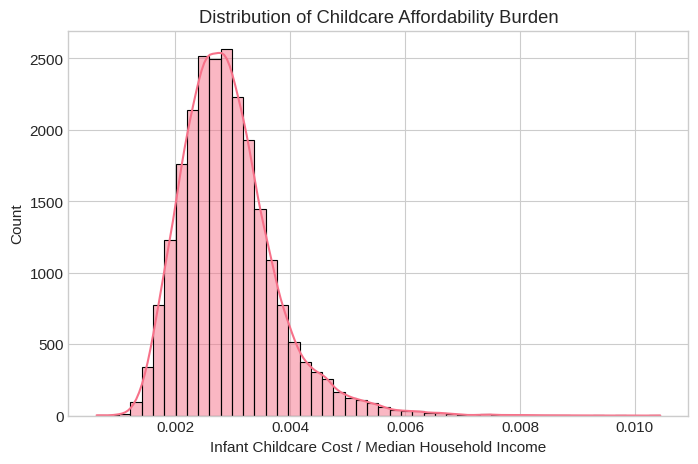

In [40]:

plt.figure(figsize=(8,5))
sns.histplot(df_childcare['infant_affordability'], bins=50, kde=True)
plt.xlabel('Infant Childcare Cost / Median Household Income')
plt.title('Distribution of Childcare Affordability Burden')
plt.show()


The distribution of infant childcare affordability burden is right-skewed, with most counties clustered at moderate levels and a small number experiencing unusually high burden. This indicates that childcare affordability challenges are concentrated in specific counties rather than evenly distributed, motivating further analysis of contextual outliers.

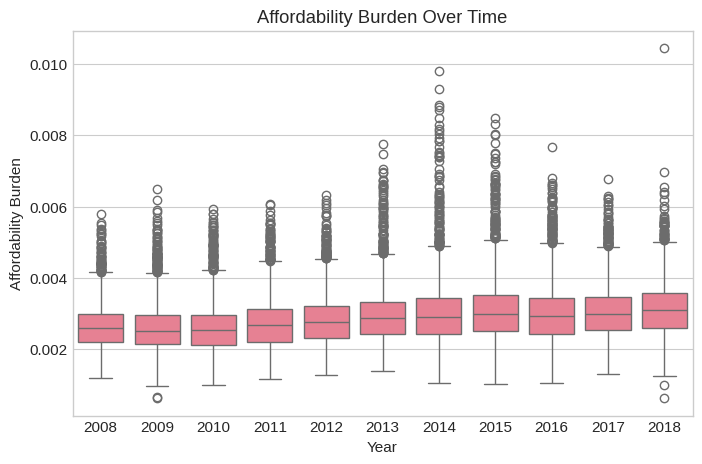

In [6]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x=df_childcare['study_year'],
    y=df_childcare['infant_affordability']
)
plt.xlabel('Year')
plt.ylabel('Affordability Burden')
plt.title('Affordability Burden Over Time')
plt.show()


Childcare affordability burden increases slightly over time, with the median rising across years and persistent high-burden outliers appearing in every period. This suggests that affordability challenges are not temporary and affect a consistent subset of counties.

## 4. Determing best K

In [51]:
# Filter year
df_2018 = df_childcare[df_childcare['study_year'] == 2018].copy()

# Affordability
df_2018['infant_affordability'] = df_2018['mc_infant'] / df_2018['mhi_2018']

# Clustering vars
cluster_vars = ['mhi_2018', 'unr_20to64', 'flfpr_20to64', 'h_under6_single_m']

df_cluster = df_2018[cluster_vars + ['infant_affordability']].dropna()


In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[cluster_vars])


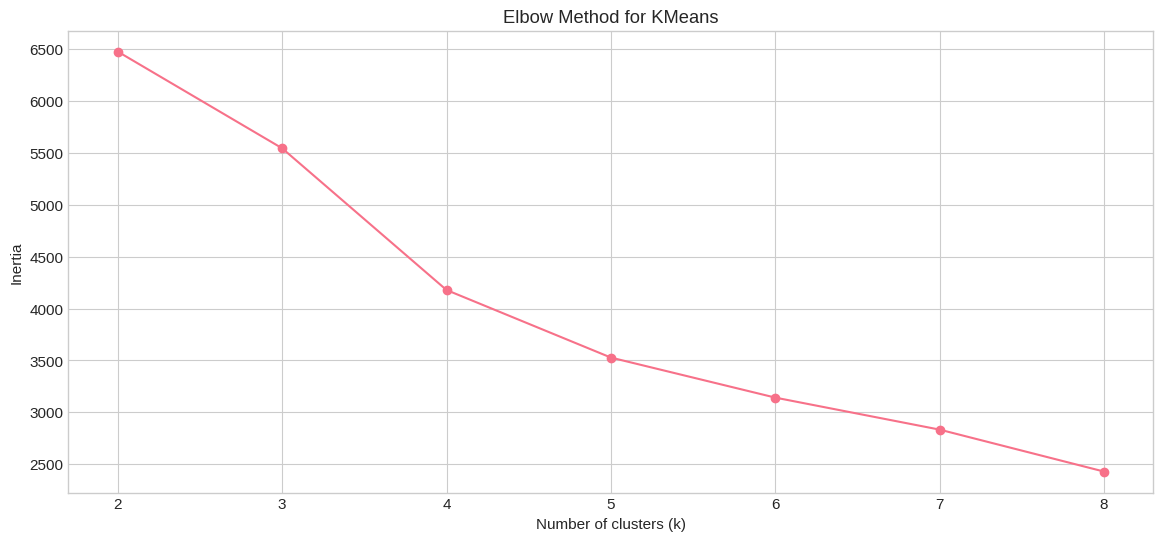

In [53]:
inertia = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans')
plt.show()


The plot shows that grouping counties into about three or four clusters greatly improves how well similar counties are grouped together. After that, adding more clusters only makes small improvements, so using around three clusters keeps the model simple while still capturing the main patterns in the data.

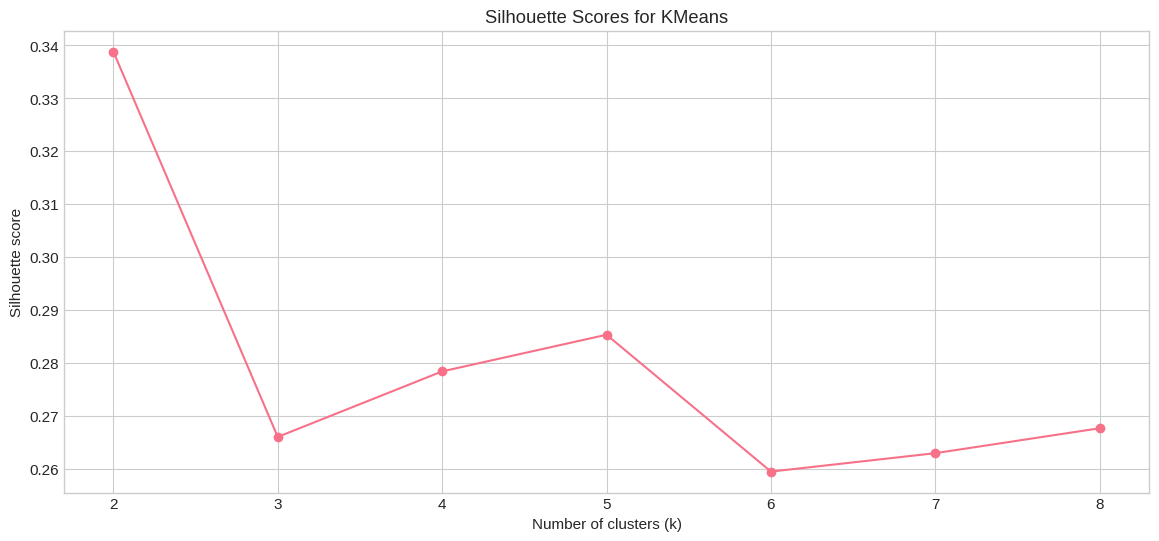

In [54]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.plot(range(2, 9), scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette Scores for KMeans')
plt.show()


The silhouette scores are highest when using a small number of clusters, indicating that counties are more clearly separated at lower values of k. While the score peaks at k = 2, using three clusters still provides reasonable separation while allowing for more meaningful distinctions among counties. Adding more clusters does not improve cluster quality and leads to weaker separation.


Considering both the elbow method and silhouette scores, I select k = 3 as it captures the main structure in the data while maintaining clear and interpretable cluster separation.

In [68]:

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[cluster_vars])

# K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Summary
df_cluster.groupby('cluster')['infant_affordability'].describe()


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,475.0,0.003361,0.000899,0.001373,0.002853,0.003336,0.003861,0.010442
1,767.0,0.003027,0.000818,0.001261,0.002419,0.002968,0.003521,0.006977
2,1118.0,0.003118,0.000713,0.000629,0.002640,0.003099,0.003503,0.006539


In [69]:

optimal_k = 3

km_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = km_final.fit_predict(X_scaled)

# Add clusters to your dataframe
df_cluster['cluster'] = cluster_labels
print(f"Cluster distribution:")
print(df_cluster['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0    1249
1    1095
2      16
Name: count, dtype: int64


Cluster 0 (1,249 counties): the largest, most common type of county

Cluster 1 (1,095 counties): another common type, slightly different context

Cluster 2 (16 counties): a small, distinct group that looks very different from the rest

The clustering results produce two large, representative county groups and one small cluster of counties with distinctly different economic and affordability characteristics, suggesting the presence of structurally unique contexts.

In [71]:
df_cluster.groupby('cluster')[cluster_vars + ['infant_affordability']].mean()


,mhi_2018,unr_20to64,flfpr_20to64,h_under6_single_m,infant_affordability
cluster,,,,,
0,60423.151321,3.833066,74.900721,2093.292234,0.003042
1,42675.847489,7.066301,63.531598,1001.078539,0.003222
2,59862.000000,6.693750,70.568750,72690.437500,0.004755


Using this to verify the cluster 2 is not the data error. Cluster 0 has the higher income, lower unemployment, high female labor participation, with the moderate childcare burden around 0.003; Cluster 1 showes lower income, higher unemployment, lower female labor participation, with the similar but slightly higher burden around 0.003; Cluster 2 indicates the mid-high income but much higher single-mother households with the highest childcare burden

In [70]:

cluster_stats = df_cluster.groupby('cluster')['infant_affordability'].agg(['mean', 'std'])
print(cluster_stats)
df_cluster['burden_z'] = (
    df_cluster.groupby('cluster')['infant_affordability']
    .transform(lambda x: (x - x.mean()) / x.std())
)
df_cluster['anomaly'] = df_cluster['burden_z'].abs() > 2
df_cluster.groupby(['cluster', 'anomaly'])['infant_affordability'].count()



             mean       std
cluster                    
0        0.003042  0.000758
1        0.003222  0.000780
2        0.004755  0.001900


cluster  anomaly
0        False      1197
         True         52
1        False      1030
         True         65
2        False        15
         True          1
Name: infant_affordability, dtype: int64

After grouping counties with similar income and labor conditions, comparing each county’s childcare affordability to others in the same group, so set burden_z = 2 to test if there is a very different from most counties in the same group.

False (not an anomaly)
This means the county’s childcare affordability is about what we would expect given its economic context. Its childcare burden is close to the average for similar counties.

True (an anomaly)
This means the county’s childcare affordability is much higher or much lower than expected compared to other counties in the same group. These counties stand out because their childcare costs do not match what their income and labor conditions would suggest, there are 52 in cluster o, 65 in cluster 1, and 1 in clsuter 2.

## 5. Cluster Statistics

In [61]:

# Show the cluster statistics
print("=== Cluster Statistics ===")
print(cluster_stats)
print()

# Count anomalies
print(f"Total anomalies detected: {df_cluster['anomaly'].sum()} counties")
print(f"Percentage: {100 * df_cluster['anomaly'].sum() / len(df_cluster):.2f}%")
print()

# Breakdown by cluster
print("=== Anomalies by Cluster ===")
anomaly_breakdown = df_cluster.groupby(['cluster', 'anomaly']).size().unstack(fill_value=0)
anomaly_breakdown['anomaly_rate'] = anomaly_breakdown[True] / (anomaly_breakdown[True] + anomaly_breakdown[False]) * 100
print(anomaly_breakdown)

=== Cluster Statistics ===
             mean       std
cluster                    
0        0.003042  0.000758
1        0.003222  0.000780
2        0.004755  0.001900

Total anomalies detected: 118 counties
Percentage: 5.00%

=== Anomalies by Cluster ===
anomaly  False  True  anomaly_rate
cluster                           
0         1197    52      4.163331
1         1030    65      5.936073
2           15     1      6.250000


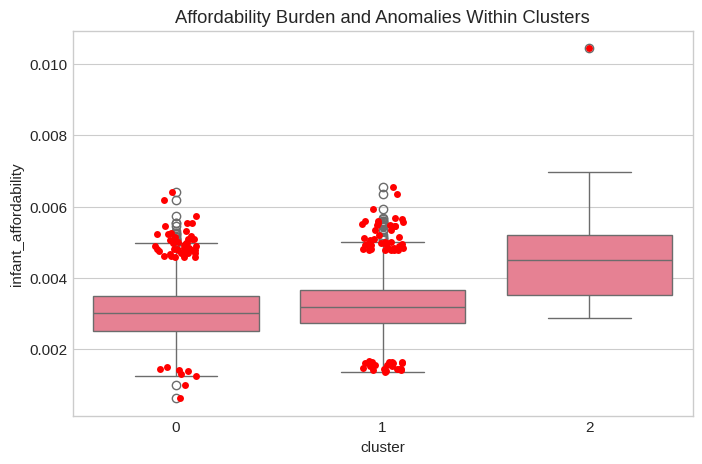

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='cluster', y='infant_affordability', data=df_cluster)
sns.stripplot(
    x='cluster',
    y='infant_affordability',
    data=df_cluster[df_cluster['anomaly']],
    color='red',
    size=5,
    jitter=True
)
plt.title('Affordability Burden and Anomalies Within Clusters')
plt.show()


Approximately 5% of counties exhibit childcare affordability levels that deviate substantially from their cluster norms, with anomalies appearing across all clusters rather than being confined to the most extreme group. Most anomalies come from Clusters 0 and 1, not Cluster 2. Cluster 2 is already extreme as a group, so fewer counties stand out within it. Even relatively typical counties can experience unexpected affordability pressure

In [63]:
# Top 10 most extreme positive anomalies (higher burden than expected)
print("\n=== TOP 10 POSITIVE ANOMALIES (Higher Burden) ===")
top_positive = df_cluster.nlargest(10, 'burden_z')[
    ['cluster', 'infant_affordability', 'burden_z', 'mhi_2018', 'unr_20to64', 'flfpr_20to64', 'h_under6_single_m']
]
print(top_positive)

# Top 10 most extreme negative anomalies (lower burden than expected)
print("\n=== TOP 10 NEGATIVE ANOMALIES (Lower Burden) ===")
top_negative = df_cluster.nsmallest(10, 'burden_z')[
    ['cluster', 'infant_affordability', 'burden_z', 'mhi_2018', 'unr_20to64', 'flfpr_20to64', 'h_under6_single_m']
]
print(top_negative)


=== TOP 10 POSITIVE ANOMALIES (Higher Burden) ===
       cluster  infant_affordability  burden_z  mhi_2018  unr_20to64  \
33972        0              0.006401  4.433498   48742.0         5.8   
2176         1              0.006539  4.248948   45528.0         6.9   
13528        0              0.006194  4.159788   64582.0         6.3   
25507        1              0.006362  4.022617   24560.0        16.7   
15134        0              0.005746  3.568931   62304.0         4.3   
2088         1              0.005940  3.482441   48443.0         8.2   
2198         0              0.005548  3.307195   52874.0         4.8   
32399        0              0.005541  3.298525   45117.0         6.9   
13462        0              0.005468  3.201789   53403.0         6.1   
20854        1              0.005690  3.161543   38134.0         3.2   

       flfpr_20to64  h_under6_single_m  
33972          76.2            30986.0  
2176           69.8             2463.0  
13528          77.5            16

The anomaly analysis identifies counties whose childcare affordability burden is much higher or lower than expected relative to similar counties. High-burden anomalies are observed primarily in otherwise typical clusters and are characterized by elevated childcare costs despite moderate household incomes and labor participation rates, suggesting localized affordability pressures not captured by broad economic indicators. In contrast, low-burden anomalies exhibit unusually affordable childcare relative to income, even in counties with average or below-average labor market conditions, indicating potential advantages from local childcare supply, informal care networks, or policy environments. Together, these patterns show that childcare affordability outcomes can diverge substantially from what economic context alone would predict, reinforcing the importance of examining local structural factors beyond income and employment.

## 6. Test sensitivity & Z-score

In [64]:
# Test sensitivity to threshold choice
thresholds = [1.5, 2.0, 2.5, 3.0]

print("\n=== Sensitivity Analysis: Z-Score Thresholds ===")
for thresh in thresholds:
    n_anomalies = (df_cluster['burden_z'].abs() > thresh).sum()
    pct = 100 * n_anomalies / len(df_cluster)
    print(f"Threshold |z| > {thresh}: {n_anomalies} counties ({pct:.2f}%)")


=== Sensitivity Analysis: Z-Score Thresholds ===
Threshold |z| > 1.5: 302 counties (12.80%)
Threshold |z| > 2.0: 118 counties (5.00%)
Threshold |z| > 2.5: 41 counties (1.74%)
Threshold |z| > 3.0: 15 counties (0.64%)


This sensitivity analysis using different z-score thresholds. Using a lower threshold (|z| > 1.5) flags a large number of counties, capturing substantial normal variation rather than clear anomalies. A higher threshold (|z| > 2.5 or |z| > 3.0) identifies only a small number of extreme cases, which may miss meaningful but less extreme deviations. A threshold of |z| > 2.0 identifies approximately 5% of counties, striking a balance between excluding routine variation and retaining substantively important cases.

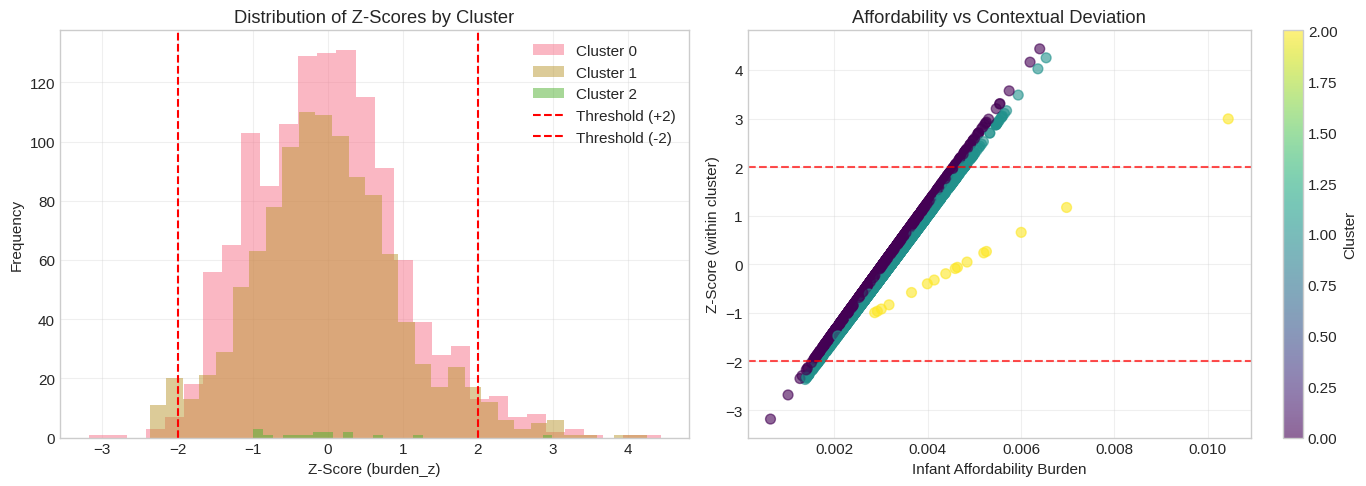

In [67]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of z-scores by cluster
for cluster in sorted(df_cluster['cluster'].unique()):
    cluster_data = df_cluster[df_cluster['cluster'] == cluster]['burden_z']
    axes[0].hist(cluster_data, alpha=0.5, label=f'Cluster {cluster}', bins=30)

axes[0].axvline(x=2, color='red', linestyle='--', label='Threshold (+2)')
axes[0].axvline(x=-2, color='red', linestyle='--', label='Threshold (-2)')
axes[0].set_xlabel('Z-Score (burden_z)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Z-Scores by Cluster')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Affordability vs Z-score
scatter = axes[1].scatter(
    df_cluster['infant_affordability'],
    df_cluster['burden_z'],
    c=df_cluster['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=50
)
axes[1].axhline(y=2, color='red', linestyle='--', alpha=0.7)
axes[1].axhline(y=-2, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Infant Affordability Burden')
axes[1].set_ylabel('Z-Score (within cluster)')
axes[1].set_title('Affordability vs Contextual Deviation')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

This figure shows the distribution of childcare affordability z-scores within each cluster. Most counties in all clusters are concentrated around zero, indicating that their childcare burden is close to the cluster average. Only a small number of counties fall beyond the ±2 threshold, confirming that these observations are genuinely unusual rather than part of normal variation.

For the Affordability vs Contextual Deviation chart, each dot means one county, so the X-axis shows how expensive childcare is relative to income, while Y-axis shows how much that county deviates from waht we expect.